# ACNets: Confirmatory Factor Analysis

We use dosenbach2007 and dosenbach2010 networks in this confirmatory factor analysis.


## 0. Setup

In [1]:

import math
import re

import numpy as np
import xarray as xr
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns; sns.set('notebook')

from sklearn import preprocessing, model_selection, metrics, ensemble, multioutput
from sklearn import decomposition, cross_decomposition, feature_selection, dummy, svm

from sklearn.pipeline import Pipeline

import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from python.acnets.datasets import load_connectivity

from copy import deepcopy

from tqdm import tqdm

from factor_analyzer import ConfirmatoryFactorAnalyzer, ModelSpecificationParser

# Technical reproducibility
%reload_ext watermark
%watermark -iv -co -ituhmv

%reload_ext autoreload
%autoreload 3

Last updated: 2022-02-23T23:27:11.846767+01:00

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

conda environment: acnets

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Hostname: MP0159

skopt     : 0.9.0
sklearn   : 1.0.2
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:28:27) 
[Clang 11.1.0 ]
numpy     : 1.21.5
xarray    : 0.21.1
seaborn   : 0.11.2
matplotlib: 3.5.1
pandas    : 1.4.0
re        : 2.2.1



# Fit the model

In [2]:
atlas = 'dosenbach2010'
connectivity_measure = 'tangent'

In [3]:
cv = model_selection.StratifiedKFold(5)

pipe = Pipeline([
  ('zv', feature_selection.VarianceThreshold()),
  # ('fa', decomposition.FactorAnalysis()),
  ('clf', svm.SVC(kernel='linear', probability=True))
])

param_space = {
  # 'fa__rotation': Categorical(['varimax']),
  # 'fa__n_components': Categorical([6]), # Integer(1, 10),
  'clf__C': Real(1e-3, 1e3, 'log-uniform'),
}

opt = BayesSearchCV(pipe, param_space, cv=cv, n_jobs=1, scoring='roc_auc')

def fit(X, y, feature_names):

  # test/train splits
  train, test = model_selection.train_test_split(
    range(len(X)),
    test_size=0.2,
    shuffle=True,
    stratify=y,)
      
  progress_bar = tqdm(total=opt.total_iterations)

  opt.fit(X[train], y[train],
          callback = [
            skopt.callbacks.DeadlineStopper(total_time=300),
            lambda _: False if progress_bar.update() else False,
  ])

  progress_bar.close()
  
  # evaluate
  score_train = opt.score(X[train], y[train])
  score_test = opt.score(X[test], y[test])

  # report scores and hyperparameters
  print(f'train set score (roc_auc): {score_train:.2f}')
  print(f'test set score (roc_auc): {score_test:.2f}')

  # we don't have a hyperparameter so we pass 'pipe' instead of 'grid'
  obs_score, perm_scores, p_value = model_selection.permutation_test_score(
    opt.best_estimator_, X, y,
    cv=cv,
    scoring='roc_auc',
    n_permutations=100,
    n_jobs=-1, verbose=0)
  
  print('obs_score,perm_scores_mean,p_value:', obs_score, perm_scores.mean(), p_value)
  
def preprocess(X, y, feature_names):
  # binarize
  X_threshold = np.array([np.median(x, keepdims=True) + x.std(keepdims=True) for x in X])
  X = np.where(np.abs(X) > X_threshold, 1, 0)

  if len(X.shape) == 3:
    X = np.array([x[np.triu_indices_from(x, k=1)] for x in X])
    feature_names = feature_names.values[np.triu_indices_from(feature_names.values, k=1)]

  # remove zero-variance features
  return X, y, feature_names


X, y, feature_names = load_connectivity(
  parcellation=atlas,
  kind=connectivity_measure,
  vectorize=False,
  return_y=True,
  only_diagonal=True,
  return_feature_names=True,
  discard_diagonal=False,
  discard_cerebellum=False,)

# encode y as integers
y_encoder = preprocessing.LabelEncoder()
y = y_encoder.fit_transform(y)


Extract network names from the atlas:

In [4]:
from nilearn import datasets as nilean_datasets

if atlas == 'dosenbach2010':
  coords = nilean_datasets.fetch_coords_dosenbach_2010(legacy_format=False)
  labels = pd.concat(
    [coords['rois'].reset_index(drop=True),
     pd.Series(coords['labels']),
     coords['networks'].reset_index(drop=True)], axis=1)
  labels.set_index(0, inplace=True)
  network_names = labels.loc[feature_names.tolist(), 'network']

elif atlas == 'dosenbach2007':
  dosenbach2007_networks = [
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    2, 2, 2, 2, 2, 2, 2,
    3, 3, 3, 3,
    4, 4,
    5, 5, 5, 5,
    6, 6, 6, 6, 6, 6, 6, 6,
    7, 7,
    8]
  network_names = pd.Series(dosenbach2007_networks, index=feature_names.tolist())

In [20]:
factors = dict.fromkeys(network_names.unique().tolist(), [])

for feat_name, net in network_names.iteritems():
  factors[net] = factors[net] + [feat_name]

factors_spec = ModelSpecificationParser.parse_model_specification_from_dict(
  X, factors)

cfa = ConfirmatoryFactorAnalyzer(factors_spec, disp=False) 

X_norm = preprocessing.StandardScaler().fit_transform(X)
X_cfa = cfa.fit_transform(X_norm)

# test/train splits
train, test = model_selection.train_test_split(
  range(len(X)),
  test_size=0.2,
  shuffle=True,
  stratify=y,)

opt.fit(X_cfa[train], y[train])
opt.score(X_cfa[test], y[test])

The optimization routine failed to converge: ABNORMAL_TERMINATION_IN_LNSRCH
The objective has been evaluated at this point before.


0.8333333333333334

Permutation testing:

In [21]:
cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

obs_score, rnd_scores, p_value = model_selection.permutation_test_score(
  opt.best_estimator_,
  X_cfa, y,
  cv=cv,
  n_permutations=100,
  scoring='roc_auc')

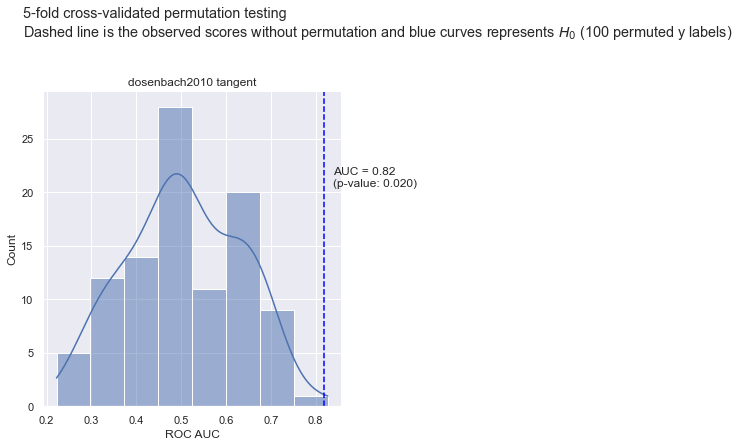

In [22]:

g = sns.displot(rnd_scores, kde=True)
# plt.vlines(obs_score, linestyles='dashed', linewidth=1)

plt.axvline(obs_score, ls='--', color='blue')

g.set(xlabel='ROC AUC')
plt.text(x=obs_score + .02,
        y=plt.gca().get_ylim()[1] * .7,
        s=f'AUC = {obs_score:.2f}\n(p-value: {p_value:.3f})')

g.ax.set_title(f'{atlas} {connectivity_measure}')
plt.suptitle('5-fold cross-validated permutation testing\n'
            'Dashed line is the observed scores without permutation '
            f'and blue curves represents $H_0$ ({100} permuted y labels)',
            y=1.2, x=.08, ha='left')
plt.show()

Assign colors to the networks and their corresponding regions:

In [23]:
palt = dict(zip(
  network_names.unique(),
  sns.color_palette('Set1', network_names.nunique())))

network_colors = network_names.apply(lambda x: pd.Series((palt[x], x)))
network_colors.rename(columns={0:'color', 1:'network'}, inplace=True)
network_colors.index.name = 'region'

Now plot the Factor Analysis components:

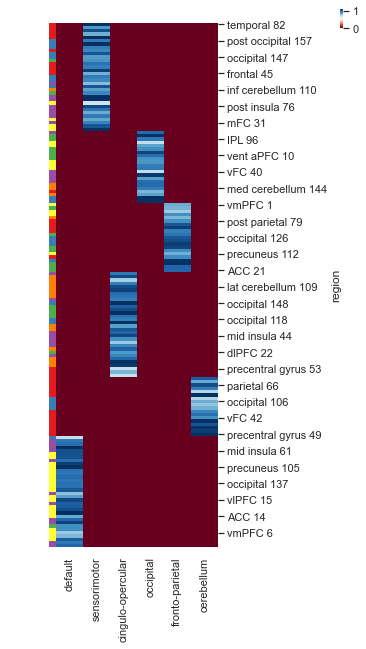

In [24]:
fa_comps = pd.DataFrame(
  cfa.loadings_,
  index=network_colors.index,
  columns=list(factors.keys())
)

sns.clustermap(fa_comps, figsize=(5,9),
               row_cluster=False,#, row_cluster=False,
               robust=True,
               dendrogram_ratio=(0.2, 0.000001),
               cbar_pos=(.96, .967, 0.01, 0.03),
               cmap='RdBu',
               row_colors=network_colors['color'].tolist())

In [25]:
network_info = pd.DataFrame(
  feature_names[cfa.loadings_.argsort(axis=0)[::-1]],
  columns=[f'network_{i}' for i in range(cfa.loadings_.shape[1])])
# network_info

In [26]:
for i, (net, feats) in enumerate(factors.items()):
  coef = opt.best_estimator_['clf'].coef_[0][i]
  print(f'{net}:\n'
        f'\tclassification coef: {coef:.2f}\n'
        f'\tnodes: {", ".join(feats)}')


sensorimotor:
	classification coef: -0.19
	nodes: temporal 82, precentral gyrus 52, precentral gyrus 51, parietal 65, frontal 32, SMA 43, parietal 54, parietal 50, parietal 69, frontal 45, mid insula 48, post parietal 79, parietal 64, parietal 74, parietal 75, mid insula 55, precentral gyrus 53, precentral gyrus 67, post insula 70, pre-SMA 41, parietal 62, parietal 66, parietal 77, mid insula 56, dFC 35, vFC 37, temporal 60, vFC 42, temporal 68, temporal 83, precentral gyrus 46, sup parietal 86, precentral gyrus 49
occipital:
	classification coef: -0.17
	nodes: post occipital 157, post occipital 159, occipital 142, occipital 133, occipital 147, temporal 123, post occipital 158, post occipital 154, post occipital 153, occipital 119, occipital 126, occipital 139, occipital 145, occipital 135, occipital 148, occipital 118, occipital 129, post occipital 152, occipital 106, post occipital 160, occipital 149, post occipital 156
fronto-parietal:
	classification coef: -1.03
	nodes: dlPFC 24, v

100%|██████████| 500/500 [00:11<00:00, 45.34it/s]


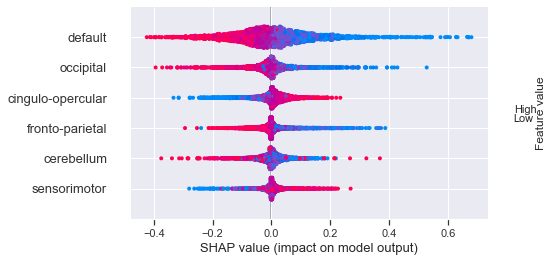

In [29]:
import shap

cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=100)
n_splits = cv.get_n_splits(X, y)

shap_values_cv = []
expected_value_cv = []
X_test_indices_cv = []
y_test_cv = []
y_pred_cv = []

model = opt.best_estimator_

for train, test in tqdm(cv.split(X, y), total=n_splits):

  model.fit(X_cfa[train], y[train])
  y_pred = model.predict(X_cfa[test])
  explainer = shap.Explainer(model.predict_proba,
                            X_cfa[train],
                            feature_names=list(factors.keys()))

  shap_values = explainer(X_cfa[test])

  shap_values_cv.append(shap_values)
  # expected_value_cv.append(explainer.expected_value)
  X_test_indices_cv.append(test)
  y_test_cv.append(y[test])
  y_pred_cv.append(y_pred)

# merge CV data
y_test = np.hstack(y_test_cv)
y_pred = np.hstack(y_pred_cv)

# merge CV SHAPs
shap_values = shap.Explanation(
  values = np.vstack([sh.values[...,1] for sh in shap_values_cv]),
  base_values = np.hstack([sh.base_values[...,1] for sh in shap_values_cv]),
  data = np.vstack([sh.data for sh in shap_values_cv]),
  feature_names=shap_values_cv[0].feature_names,
  compute_time=np.sum([sh.compute_time for sh in shap_values_cv]),
  output_names=y_encoder.classes_,
  output_indexes=y_pred,
)

shap.plots.beeswarm(shap_values)

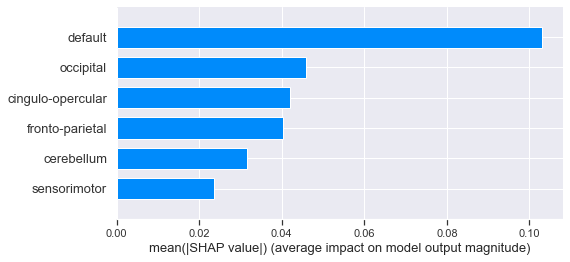

In [30]:
shap.summary_plot(deepcopy(shap_values), plot_type='bar')

## Permutation Importance

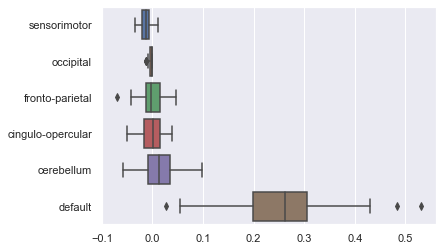

In [31]:
from sklearn.inspection import permutation_importance

perm_imp_result = permutation_importance(opt.best_estimator_, X_cfa, y, 
                                         n_repeats=100,
                                         scoring='roc_auc', n_jobs=-1)

perm_sorted_idx = perm_imp_result.importances_mean.argsort()

perm_df = pd.DataFrame(perm_imp_result.importances[perm_sorted_idx].T,
             columns=factors.keys())
sns.boxplot(
    data=perm_df,
    orient='horizontal',
#     labels=feature_names[perm_sorted_idx],
)


plt.show()